In [1]:
import os,glob
from skimage import segmentation,feature,morphology,exposure,measure,graph,filters,util
import tifffile
import matplotlib.pyplot as plt
from skimage.util import invert
import numpy as np
import pandas as pd
import timeit
import re
import multiprocessing as mp

In [2]:
cd ~/PycharmProjects/IMYG_2/

/Users/jz-rolling/PycharmProjects/IMyG_2


In [3]:
import IMyG as im

In [26]:
def generate_96_well_plate():
    rows = ["A","B","C","D","E","F","G","H"]
    columns = np.linspace(1,12,12).astype(int)
    plate = pd.DataFrame(0,index=rows,columns=columns)
    return(plate)
    
def read_from_plate(input_path,plate,n_cores = 4):
    files = glob.glob(input_path+"*.nd2")
    output_path = input_path+"output/"
    pattern = re.compile("Well([A-Z])([0-9]{1,2})")
    if len(files) == 0:
        print("Empty folder!")
    else:
        print("%d .nd2 files found in input directory."%(len(files)))
    if not os.path.isdir(output_path):
        os.mkdir(output_path)
    count_plate = generate_96_well_plate()
    for i in range(0,len(files),n_cores):
        processes = []
        for j in range(0,min(n_cores,len(files)-i)):
            file = files[i+j]
            row,column = re.search(pattern,file).group(1),re.search(pattern,file).group(2)
            #print(row,int(column))
            count = count_plate[int(column)][row]
            #print(count)
            subfolder = output_path+"Well_{}{}/".format(row,column)
            if not os.path.isdir(subfolder):
                os.mkdir(subfolder)
            count_plate[int(column)][row]+=1
            header = "{}_{}{}_{}".format(plate,row,column,count)
            processes.append(mp.Process(target=im.IO.pickel_dump,args=(file,subfolder,header,count)))
        for p in processes:
            p.start()
        for p in processes:
            p.join()
    count_plate.to_excel(output_path+"plate_count.xls")
    return(count_plate)

In [5]:
read_from_plate("/Volumes/Sam/MSR1_IDW/plate1_raw_files/0709_raw_files/","MSR1_0709")

158 .nd2 files found in input directory.


,1,2,3,4,5,6,7,8,9,10,11,12
A,0,0,0,0,0,0,0,0,0,0,0,0
B,0,0,0,0,0,0,6,7,5,3,2,0
C,0,0,0,0,0,0,8,4,7,8,0,0
D,0,0,0,0,0,0,8,8,7,8,6,0
E,0,0,0,0,0,0,2,7,8,7,8,0
F,0,0,0,0,0,0,0,0,6,8,6,0
G,0,0,0,0,0,0,2,5,5,5,2,0
H,0,0,0,0,0,0,0,0,0,0,0,0


In [27]:
root_folder = "/Volumes/Sam/"
MSR_folders = glob.glob(root_folder+"MSR*_IDW/")
#pattern = re.compile("(MSR[0-9]{1,2})")


for i in [13]:
    folder = root_folder+"MSR{}_IDW/".format(i)
    name = folder.split("/")[-2]
    plate = "MSR{}".format(i)
    subfolders = glob.glob(folder+"*raw_files/")
    if len(subfolders) == 1:
        print("Processing plate %s"%(plate))
        if len(glob.glob(subfolders[0]+"*raw_files/"))!=0:
            for babyfolder in glob.glob(subfolders[0]+"*raw_files/"):
                count_plate = read_from_plate(babyfolder,plate)
        else:
            count_plate = read_from_plate(subfolders[0],plate)
"""
folder = root_folder+"MSR_PP1_IDW/"
name = folder.split("/")[-2]
plate = "MSR_PP1"
subfolders = glob.glob(folder+"*raw_files/")
if len(subfolders) == 1:
    print("Processing plate %s"%(plate))
    if len(glob.glob(subfolders[0]+"*raw_files/"))!=0:
        for babyfolder in glob.glob(subfolders[0]+"*raw_files/"):
            count_plate = read_from_plate(babyfolder,plate)
    else:
        count_plate = read_from_plate(subfolders[0],plate)
"""

Processing plate MSR13
100 .nd2 files found in input directory.


'\nfolder = root_folder+"MSR_PP1_IDW/"\nname = folder.split("/")[-2]\nplate = "MSR_PP1"\nsubfolders = glob.glob(folder+"*raw_files/")\nif len(subfolders) == 1:\n    print("Processing plate %s"%(plate))\n    if len(glob.glob(subfolders[0]+"*raw_files/"))!=0:\n        for babyfolder in glob.glob(subfolders[0]+"*raw_files/"):\n            count_plate = read_from_plate(babyfolder,plate)\n    else:\n        count_plate = read_from_plate(subfolders[0],plate)\n'

In [7]:
np.random.shuffle(np.arange(5))

In [5]:
im.IO.pickel_dump("/Users/rubinlab_imaging/Desktop/NDExp_WellB08_Point0003_Seq0131 copy.nd2",\
                  "/Users/rubinlab_imaging/Desktop/","test_2",plate_idx=1)

In [19]:
nd = im.IO.process_nd2_no_output("/Users/jz-rolling/PycharmProjects/IMYG/Data/demo3.nd2")

In [5]:
import pickle as pk

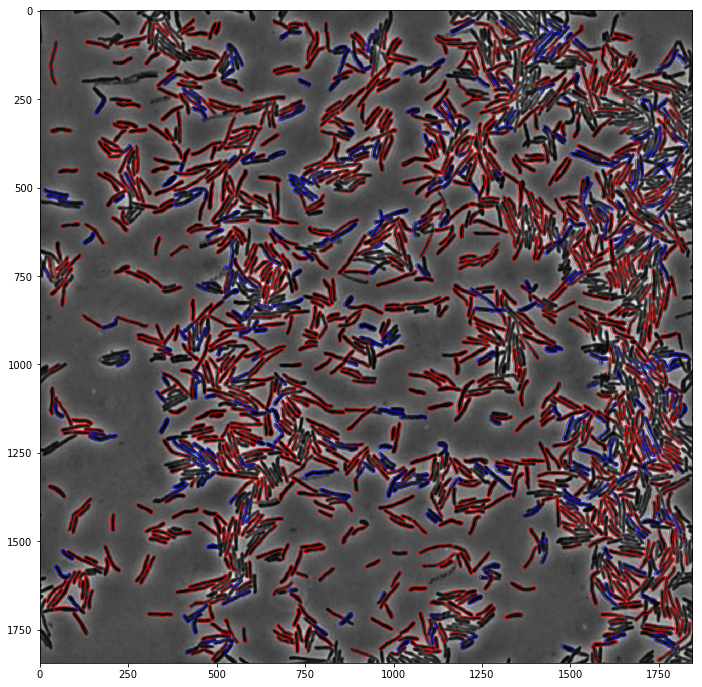

In [20]:
fig = plt.figure(figsize=(12,12))
plt.imshow(nd.ph_filtered.T,cmap = "gist_gray")
for cell in nd.cells:
    (x1,y1,x2,y2) = cell.bbox
    contour = cell.optimized_contour[0]
    xy = contour[:-1]
    adjusted_xy = np.array([xy.T[0]+x1,xy.T[1]+y1]).T
    plt.plot(adjusted_xy.T[0],adjusted_xy.T[1],c="r",linewidth = 0.5)
    
for cell in nd.celllike:
    (x1,y1,x2,y2) = cell.bbox
    contour = cell.init_contour[0]
    xy = contour[:-1]
    adjusted_xy = np.array([xy.T[0]+x1,xy.T[1]+y1]).T
    plt.plot(adjusted_xy.T[0],adjusted_xy.T[1],c="blue",linewidth = 0.5)

In [7]:
cells = pk.load(open("/Users/rubinlab_imaging/Desktop/test_2_plate_1_cells.pk","rb"))
print(len(cells))

551


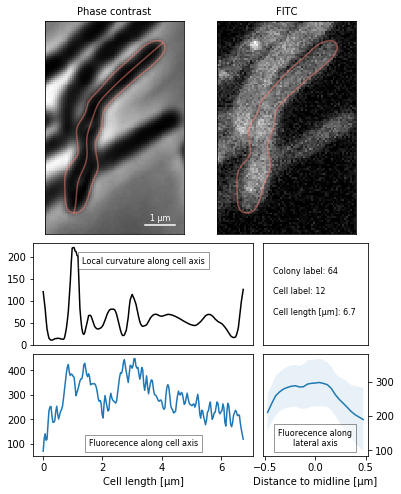

In [176]:
def vector_plot(data,ax,transverse = False):
    if data.shape[1] == 2:
        data = data.T
    if not transverse:
        ax.plot(data[1],data[0],color = 'salmon',alpha = 0.5)
    else:
        ax.plot(data[0],data[1],color = 'salmon',alpha = 0.5)

image = nd
from matplotlib.gridspec import GridSpec
transverse = False
(h,w) = cell.mask.shape
if h<w:
    transverse = True
    phase = cell.phase.T
else:
    phase = cell.phase
(x1,y1,x2,y2) = cell.bbox
n_fl_channels = len(nd.fl_img)
plot_width = 3*(n_fl_channels+1)
plot_height = 4+2*(n_fl_channels+1)
fig = plt.figure(figsize=(plot_width,plot_height))
gs = GridSpec(plot_height,plot_width)
ax1 = fig.add_subplot(gs[0:4,0:3])
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.imshow(phase,"gist_gray")
ax1.set_title("Phase contrast",fontsize = 10)
vector_plot(cell.optimized_contour[0],ax1,transverse = transverse)
vector_plot(cell.midline,ax1,transverse = transverse)
channel_counter = 1
len_two_micron = 1/cell.pixel_microns
if not transverse:
    bar_x,bar_y = w-5,h-5
else:
    bar_x,bar_y = h-5,w-5
ax1.plot([bar_x,bar_x-len_two_micron],[bar_y,bar_y],color = "white",alpha = 1)
ax1.text(bar_x-0.5*len_two_micron,bar_y-2,"1 μm",\
         fontsize = 8,color = "w",horizontalalignment='center')
for channel,fl in image.fl_img.items():
    fl_ax = fig.add_subplot(gs[0:4,3:3+3*channel_counter])
    channel_counter +=1
    fl_ax.get_xaxis().set_visible(False)
    fl_ax.get_yaxis().set_visible(False)
    data = fl[x1:x2,y1:y2]
    if transverse:
        data = data.T
    fl_ax.imshow(data,cmap = "gist_gray")
    vector_plot(cell.optimized_contour[0],fl_ax,transverse = transverse)
    fl_ax.set_title(channel,fontsize = 10)
shp_idx = cell.measure_along_midline["Shape_indexed"]
ax3 = fig.add_subplot(gs[4:6,:-2])
ax3.get_xaxis().set_visible(False)
ax3.plot(shp_idx,color = "black")
ax3.text(0.5,0.8,"Local curvature along cell axis",fontsize = 8,\
         horizontalalignment='center',transform=ax3.transAxes,\
         bbox = dict(facecolor='white', alpha=0.4))
ax4 = fig.add_subplot(gs[4:6,-2:])
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)
ax4.text(0.1,0.7,"Colony label: "+str(cell.colony_label),fontsize = 8)
ax4.text(0.1,0.5,"Cell label: "+str(cell.cell_label),fontsize = 8)
ax4.text(0.1,0.3,"Cell length [μm]: "+str(round(cell.length,1)),fontsize = 8)
channel_counter = 0
for channel,fl in image.fl_img.items():
    fl_measure = fig.add_subplot(gs[6+2*channel_counter:6+2*channel_counter+2,:-2])
    data = cell.measure_along_midline[channel]
    x_axial = np.linspace(0,cell.length,len(data))
    fl_measure.plot(x_axial,data)
    fl_measure.set_xlabel("Cell length [μm]")
    fl_measure.text(0.5,0.1,"Fluorecence along cell axis",fontsize = 8,\
                    horizontalalignment='center',transform=fl_measure.transAxes,\
                    bbox = dict(facecolor='white', alpha=0.4))
    fl_lateral = fig.add_subplot(gs[6+2*channel_counter:6+2*channel_counter+2,-2:])
    lateral_data = cell.fl_straighten[channel]
    mean,std = lateral_data[0],lateral_data[1]
    maxwidth = cell.width.max()*cell.pixel_microns
    x_lateral = np.linspace(-0.5*maxwidth,0.5*maxwidth,len(mean))
    fl_lateral.plot(x_lateral,mean)
    fl_lateral.fill_between(x_lateral,mean-std,mean+std,alpha=0.1)
    fl_lateral.get_yaxis().tick_right()
    fl_lateral.set_xlabel("Distance to midline [μm]")
    fl_lateral.text(0.5,0.1,"Fluorecence along\nlateral axis",fontsize = 8,\
                    horizontalalignment='center',transform=fl_lateral.transAxes,\
                    bbox = dict(facecolor='white', alpha=0.4))
    channel_counter +=1

In [8]:
import nd2reader

In [7]:
nd = im.IO.process_nd2_no_output("/Users/rubinlab_imaging/Desktop/NDExp_WellG01_Point0000_Seq0096.nd2")

In [22]:
n = 0
for i in range(len(nd.cells)):
    if nd.cells[i].cell_label == 0:
        print(i)
        n+=1
        if n ==10:
            break

930
931
950
951
952
953


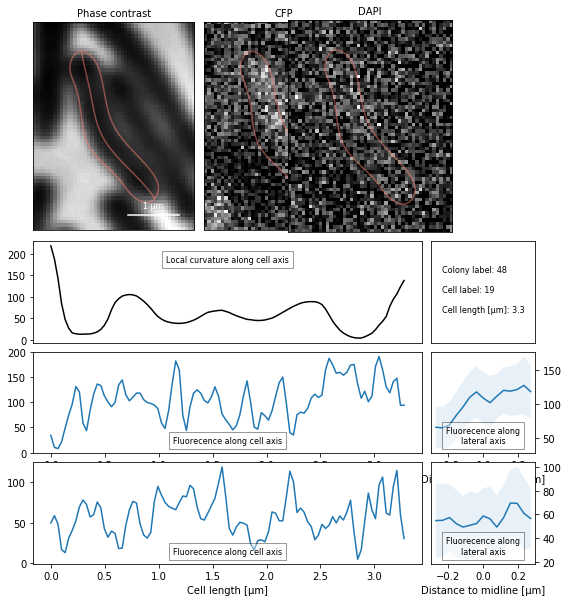

In [32]:
nd.cells[166].plot_advanced(nd)

In [6]:
pattern = re.compile("Well([A-Z])([0-9]{1,2})")

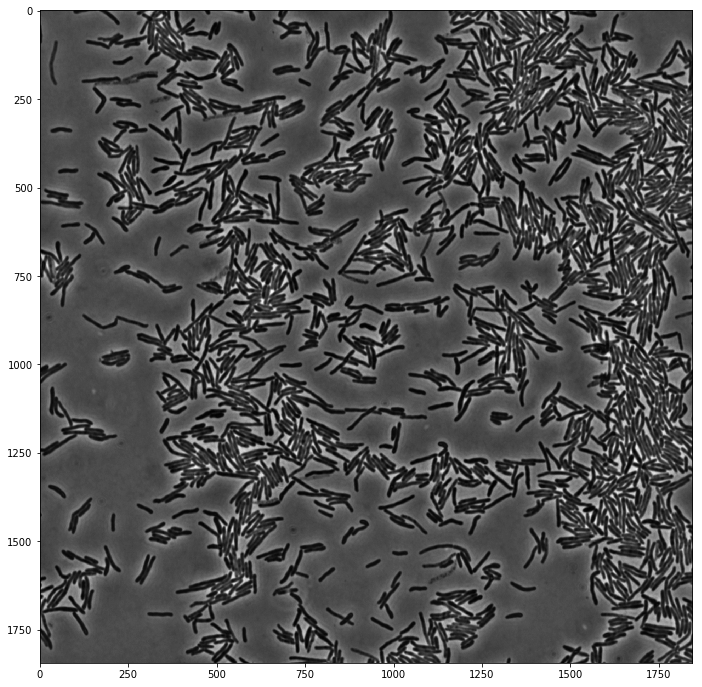

In [27]:
fig.savefig("/Users/jz-rolling/Desktop/summary/contours.png",bbox_inches = "tight",dpi = 300)
fig2 = plt.figure(figsize=(12,12))
plt.imshow(nd.ph_filtered.T,cmap = "gist_gray")
fig2.savefig("/Users/jz-rolling/Desktop/summary/ph.png",bbox_inches = "tight",dpi = 300)

In [24]:
files = glob.glob("/Volumes/Sam/MSR13_IDW/10182019_raw_files/*.nd2")

In [25]:
rootpath = "/Volumes/Sam/MSR13_IDW/10182019_raw_files/"
for file in files:
    filename = file.split("/")[-1]
    os.rename(file,rootpath+"Well"+filename)

In [13]:
files

[]